In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import os
import sklearn as skl
from sklearn.metrics import f1_score
from sklearn import tree

from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from scipy.sparse import csr_matrix
import re
import csv


In [2]:
### Q1

base_dir = os.path.dirname(os.path.realpath('_file_'))
IMDB_train_dir = base_dir + "/Datasets/IMDB-train.txt"
IMDB_test_dir = base_dir + "/Datasets/IMDB-test.txt"
IMDB_valid_dir = base_dir + "/Datasets/IMDB-valid.txt"
yelp_train_dir = base_dir + "/Datasets/yelp-train.txt"
yelp_test_dir = base_dir + "/Datasets/yelp-test.txt"
yelp_valid_dir = base_dir + "/Datasets/yelp-valid.txt"

In [3]:
def retrieve_data(fileName):
    data = pd.read_csv(fileName, sep='\t', header=None, skipinitialspace=True).dropna(axis=1, how="all")
    data_reviews  = np.array(data[0].str.lower().str.replace('[^a-zA-Z\s]','').as_matrix())
    data_class = data[1].as_matrix()
    return data, data_reviews, data_class
    
IMDB_train, IMDB_train_reviews, IMDB_train_class = retrieve_data(IMDB_train_dir)
yelp_train, yelp_train_reviews, yelp_train_class = retrieve_data(yelp_train_dir)

IMDB_valid, IMDB_valid_reviews, IMDB_valid_class = retrieve_data(IMDB_valid_dir)
yelp_valid, yelp_valid_reviews, yelp_valid_class = retrieve_data(yelp_valid_dir)

IMDB_test, IMDB_test_reviews, IMDB_test_class = retrieve_data(IMDB_test_dir)
yelp_test, yelp_test_reviews, yelp_test_class = retrieve_data(yelp_test_dir)



In [4]:
def process_data(train_data):
    vctzr = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
    vctr = vctzr.fit_transform(train_data)
    frequency = np.ravel(vctr.sum(axis=0))
    voc = [v[0] for v in sorted(vctzr.vocabulary_.items(), key=itemgetter(1))]
    freq_dist = np.array(sorted(dict(zip(voc, frequency)).items(), key=itemgetter(1), reverse=True))
    wordDict = {}
    wordFreq = freq_dist[:10000, :]
    for word in wordFreq[:10000, 0]:
        wordDict.setdefault(word, len(wordDict)+ 1)
    voc = np.insert(wordFreq, 1, np.fromiter(wordDict.values(), dtype=int), axis=1)
    return wordDict, voc


IMDB_dict, IMDB_vocab = process_data(IMDB_train_reviews)
yelp_dict, yelp_vocab = process_data(yelp_train_reviews)


In [5]:
def create_bags(reviews, dictionary):
    binary_bag = []
    freq_bag = []
    all_review_IDs = []
    for review in reviews:
        reviewWords = np.array(review.split())
        reviewIDs = []

        review_bin_bag = review_freq_bag = np.zeros((10000,), dtype=int)

        for word in reviewWords:
            if word in dictionary:
                review_bin_bag[dictionary[word]-1] = 1
                review_freq_bag[dictionary[word]-1] += 1
                reviewIDs.append(dictionary[word])
        binary_bag.append(review_bin_bag)
        if(np.sum(review_freq_bag, axis=0) != 0):
            freq_bag.append(review_freq_bag / np.sum(review_freq_bag, axis=0))
        else:
            freq_bag.append(review_freq_bag)
        all_review_IDs.append(np.asarray(reviewIDs))
    return all_review_IDs, csr_matrix(binary_bag), csr_matrix(freq_bag)


IMDB_review_IDs_train, IMDB_binary_train, IMDB_freq_train = create_bags(IMDB_train_reviews, IMDB_dict)
IMDB_review_IDs_test, IMDB_binary_test, IMDB_freq_test = create_bags(IMDB_test_reviews, IMDB_dict)
IMDB_review_IDs_valid, IMDB_binary_valid, IMDB_freq_valid = create_bags(IMDB_valid_reviews, IMDB_dict)
yelp_review_IDs_train, yelp_binary_train, yelp_freq_train = create_bags(yelp_train_reviews, yelp_dict)
yelp_review_IDs_test, yelp_binary_test, yelp_freq_test = create_bags(yelp_test_reviews, yelp_dict)
yelp_review_IDs_valid, yelp_binary_valid, yelp_freq_valid = create_bags(yelp_valid_reviews, yelp_dict)


In [6]:
def append_reviews(reviews, data):
    vectors = list()
    for review in reviews:
        vectors.append(" ".join(str(x) for x in review))
    return np.c_[vectors, data]


IMDB_train = append_reviews(IMDB_review_IDs_train,  IMDB_train_class )
IMDB_test = append_reviews(IMDB_review_IDs_test,  IMDB_test_class )
IMDB_valid = append_reviews(IMDB_review_IDs_valid,  IMDB_valid_class )
yelp_train = append_reviews(yelp_review_IDs_train,  yelp_train_class )
yelp_test = append_reviews(yelp_review_IDs_test,  yelp_test_class )
yelp_valid = append_reviews(yelp_review_IDs_valid,  yelp_valid_class )

In [7]:
def df_to_csv(vocabulary, fileName) :
    pd.DataFrame(vocabulary).to_csv(fileName, sep='\t', encoding='utf-8', header=None, index=False, quoting=csv.QUOTE_NONE)

df_to_csv(IMDB_vocab, "IMDB-vocab.txt")
df_to_csv(yelp_vocab, "yelp-vocab.txt")

df_to_csv(IMDB_train, "IMDB-train.txt" )
df_to_csv(IMDB_test, "IMDB-test.txt" )
df_to_csv(IMDB_valid, "IMDB-valid.txt" )

df_to_csv(yelp_train, "yelp-train.txt" )
df_to_csv(yelp_test, "yelp-test.txt" )
df_to_csv(yelp_valid, "yelp-valid.txt" )


In [8]:
### Q2


#Yelp 


rand_train = np.random.choice([1,2,3,4,5], len(yelp_train_class))
rand_valid = np.random.choice([1,2,3,4,5], len(yelp_valid_class))
rand_test = np.random.choice([1,2,3,4,5], len(yelp_test_class))

majority_train = np.argmax(np.bincount(yelp_train_class))
majority_valid = np.argmax(np.bincount(yelp_valid_class))
majority_test = np.argmax(np.bincount(yelp_test_class))
majority_array_valid = np.array([majority_valid]*len(yelp_valid_class))
majority_array_train = np.array([majority_train]*len(yelp_train_class))
majority_array_test = np.array([majority_test]*len(yelp_test_class))

print("Yelp - Binary Bag")
print("Random Classifier")
print("F1 train: ", skl.metrics.f1_score(yelp_train_class, rand_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(yelp_valid_class, rand_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(yelp_test_class, rand_test, average='macro'))
print("\n")



print("Majority Classifier")
print("F1 Train: ", skl.metrics.f1_score(yelp_train_class, majority_array_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(yelp_valid_class, majority_array_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(yelp_test_class, majority_array_test, average='macro'))
print("\n")





Yelp - Binary Bag
Random Classifier
F1 train:  0.18120189443216356
F1 Valid:  0.16733179661207848
F1 Test:  0.1867629398371078


Majority Classifier
F1 Train:  0.10426700464723279
F1 Valid:  0.10501474926253689
F1 Test:  0.10392301998519615




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0,0.5,'F_Measure')

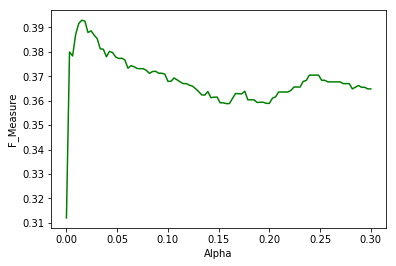

In [9]:
alphas = np.linspace(0.000001, 0.3, 100)
f1_measures = []
for a in alphas:
    classifier = skl.naive_bayes.BernoulliNB(alpha=a)
    classifier.fit(yelp_binary_train, yelp_train_class)
    result = classifier.predict(yelp_binary_valid)
    f1_measures.append(skl.metrics.f1_score(yelp_valid_class, result, average='macro'))


plt.plot(alphas, f1_measures, c='g')
plt.xlabel("Alpha")
plt.ylabel("F_Measure")


In [10]:
print("Naive Bayes Classifier")


best_alpha = alphas[np.argmax(f1_measures)]
print("Best Alpha:  " + str(best_alpha))
print("F1 with best alpha: " + str(np.max(f1_measures)))

classifier = skl.naive_bayes.BernoulliNB(alpha=best_alpha)
classifier.fit(yelp_binary_train, yelp_train_class)

result_train = classifier.predict(yelp_binary_train)
result_test = classifier.predict(yelp_binary_test)
result_valid = classifier.predict(yelp_binary_valid)


print("F1 Train: ", skl.metrics.f1_score(yelp_train_class, result_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(yelp_valid_class, result_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(yelp_test_class, result_test, average='macro'))
print("\n")


Naive Bayes Classifier
Best Alpha:  0.015152464646464647
F1 with best alpha: 0.3929145459683094
F1 Train:  0.7654692922969333
F1 Valid:  0.3929145459683094
F1 Test:  0.36940002171711317




In [11]:
print("Decision Tree Classifier")

classifier  = tree.DecisionTreeClassifier()
classifier.fit(yelp_binary_train, yelp_train_class)
    
result_train = classifier.predict(yelp_binary_train)
result_test = classifier.predict(yelp_binary_test)
result_valid = classifier.predict(yelp_binary_valid)

print("F1 Train: ", skl.metrics.f1_score(yelp_train_class, result_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(yelp_valid_class, result_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(yelp_test_class, result_test, average='macro'))
print("\n")


Decision Tree Classifier
F1 Train:  1.0
F1 Valid:  0.29200475534809617
F1 Test:  0.29242246381464165




In [22]:
##SVM binary

f1_measures = []

classifier = skl.svm.LinearSVC(penalty="l1", dual=False)
classifier.fit(yelp_binary_train, yelp_train_class)
result = classifier.predict(yelp_binary_valid)
f1_measures.append(skl.metrics.f1_score(yelp_valid_class, result, average='macro'))
           
classifier = skl.svm.LinearSVC(penalty="l2", loss="hinge")
classifier.fit(yelp_binary_train, yelp_train_class)
result = classifier.predict(yelp_binary_valid)
f1_measures.append(skl.metrics.f1_score(yelp_valid_class, result, average='macro'))

classifier = skl.svm.LinearSVC(penalty="l2", loss="squared_hinge")
classifier.fit(yelp_binary_train, yelp_train_class)
result = classifier.predict(yelp_binary_valid)
f1_measures.append(skl.metrics.f1_score(yelp_valid_class, result, average='macro'))
        
arg = np.argmax(f1_measures)
p="l2"
l = "hinge"
if arg==2:
    l = "squared_hinge"
if(arg==0):
    p= "l1"
    l = "-"
    classifier = skl.svm.LinearSVC(penalty=p, dual=False)
else:
    classifier = skl.svm.LinearSVC(penalty=p, loss=l)

    
print("Linear SVM Classifier")
print("Loss " + str(l))
print("Penalty " + str(p))

classifier.fit(yelp_binary_train, yelp_train_class)
result = classifier.predict(yelp_binary_test)


result_train = classifier.predict(yelp_binary_train)
result_test = classifier.predict(yelp_binary_test)
result_valid = classifier.predict(yelp_binary_valid)

print("F1 Train: ", skl.metrics.f1_score(yelp_train_class, result_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(yelp_valid_class, result_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(yelp_test_class, result_test, average='macro'))
print("\n")


Linear SVM Classifier
Loss squared_hinge
Penalty l2
F1 Train:  0.9991546021160594
F1 Valid:  0.41022513701013946
F1 Test:  0.3955976281814554




In [13]:
### Q3

print("Yelp - Frequency Bag")

print("Naive Bayes Classifier")

classifier = skl.naive_bayes.GaussianNB()
classifier.fit(yelp_freq_train.toarray(), yelp_train_class)

result_train = classifier.predict(yelp_freq_train.toarray())
result_test = classifier.predict(yelp_freq_test.toarray())
result_valid = classifier.predict(yelp_freq_valid.toarray())


print("F1 Train: ", skl.metrics.f1_score(yelp_train_class, result_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(yelp_valid_class, result_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(yelp_test_class, result_test, average='macro'))
print("\n")


Yelp - Frequency Bag
Naive Bayes Classifier
F1 Train:  0.7428255483490837
F1 Valid:  0.25803799016927587
F1 Test:  0.24630966964557435




In [14]:

print("Decision Tree Classifier")

classifier  = tree.DecisionTreeClassifier()
classifier.fit(yelp_freq_train, yelp_train_class)
    
result_train = classifier.predict(yelp_freq_train)
result_test = classifier.predict(yelp_freq_test)
result_valid = classifier.predict(yelp_freq_valid)


print("F1 Train: ", skl.metrics.f1_score(yelp_train_class, result_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(yelp_valid_class, result_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(yelp_test_class, result_test, average='macro'))
print("\n")


Decision Tree Classifier
F1 Train:  1.0
F1 Valid:  0.2772497549383351
F1 Test:  0.2825438356276414




In [15]:
##SVM binary

f1_measures = []

classifier = skl.svm.LinearSVC(penalty="l1", dual=False)
classifier.fit(yelp_freq_train, yelp_train_class)
result = classifier.predict(yelp_freq_valid)
f1_measures.append(skl.metrics.f1_score(yelp_valid_class, result, average='macro'))
           
classifier = skl.svm.LinearSVC(penalty="l2", loss="hinge")
classifier.fit(yelp_freq_train, yelp_train_class)
result = classifier.predict(yelp_freq_valid)
f1_measures.append(skl.metrics.f1_score(yelp_valid_class, result, average='macro'))

classifier = skl.svm.LinearSVC(penalty="l2", loss="squared_hinge")
classifier.fit(yelp_freq_train, yelp_train_class)
result = classifier.predict(yelp_freq_valid)
f1_measures.append(skl.metrics.f1_score(yelp_valid_class, result, average='macro'))
        
arg = np.argmax(f1_measures)
p="l2"
l = "hinge"
if arg==2:
    l = "squared_hinge"
if(arg==0):
    p= "l1"
    l = "-"
    classifier = skl.svm.LinearSVC(penalty=p, dual=False)
else:
    classifier = skl.svm.LinearSVC(penalty=p, loss=l)

    
print("Decision Tree Classifier")
print("Loss " + str(l))
print("Penalty " + str(p))

classifier.fit(yelp_freq_train, yelp_train_class)
result = classifier.predict(yelp_freq_test)


result_train = classifier.predict(yelp_freq_train)
result_test = classifier.predict(yelp_freq_test)
result_valid = classifier.predict(yelp_freq_valid)

print("F1 Train: ", skl.metrics.f1_score(yelp_train_class, result_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(yelp_valid_class, result_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(yelp_test_class, result_test, average='macro'))
print("\n")

Decision Tree Classifier
Loss hinge
Penalty l2
F1 Train:  0.5792233017783223
F1 Valid:  0.36660610717247205
F1 Test:  0.35203522213951255




In [16]:
#### Q4

#IMDB


rand_train = np.random.choice([1,2,3,4,5], len(IMDB_train_class))
rand_valid = np.random.choice([1,2,3,4,5], len(IMDB_valid_class))
rand_test = np.random.choice([1,2,3,4,5], len(IMDB_test_class))

print("IMDB - Binary Bag")
print("Random Classifier")
print("F1 train: ", skl.metrics.f1_score(IMDB_train_class, rand_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(IMDB_valid_class, rand_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(IMDB_test_class, rand_test, average='macro'))
print("\n")



IMDB - Binary Bag
Random Classifier
F1 train:  0.046364126470681506
F1 Valid:  0.04756463362376803
F1 Test:  0.04806077263704383




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0,0.5,'F_Measure')

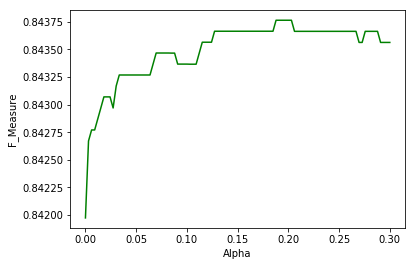

In [17]:
alphas = np.linspace(0.000001, 0.3, 100)
f1_measures = []
for a in alphas:
    classifier = skl.naive_bayes.BernoulliNB(alpha=a)
    classifier.fit(IMDB_binary_train, IMDB_train_class)
    result = classifier.predict(IMDB_binary_valid)
    f1_measures.append(skl.metrics.f1_score(IMDB_valid_class, result, average='macro'))


plt.plot(alphas, f1_measures, c='g')
plt.xlabel("Alpha")
plt.ylabel("F_Measure")


In [18]:
print("Naive Bayes Classifier")


best_alpha = alphas[np.argmax(f1_measures)]
print("Best Alpha:  " + str(best_alpha))
print("F1 with best alpha: " + str(np.max(f1_measures)))

classifier = skl.naive_bayes.BernoulliNB(alpha=best_alpha)
classifier.fit(IMDB_binary_train, IMDB_train_class)

result_train = classifier.predict(IMDB_binary_train)
result_test = classifier.predict(IMDB_binary_test)
result_valid = classifier.predict(IMDB_binary_valid)


print("F1 Train: ", skl.metrics.f1_score(IMDB_train_class, result_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(IMDB_valid_class, result_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(IMDB_test_class, result_test, average='macro'))
print("\n")


Naive Bayes Classifier
Best Alpha:  0.18787916161616164
F1 with best alpha: 0.8437639032121982
F1 Train:  0.8704249947690955
F1 Valid:  0.8437639032121982
F1 Test:  0.8317881814509224




In [19]:
print("Decision Tree Classifier")

classifier  = tree.DecisionTreeClassifier()
classifier.fit(IMDB_freq_train, IMDB_train_class)
    
result_train = classifier.predict(IMDB_freq_train)
result_test = classifier.predict(IMDB_freq_test)
result_valid = classifier.predict(IMDB_freq_valid)


print("F1 Train: ", skl.metrics.f1_score(IMDB_train_class, result_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(IMDB_valid_class, result_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(IMDB_test_class, result_test, average='macro'))
print("\n")

Decision Tree Classifier
F1 Train:  1.0
F1 Valid:  0.6810747379299914
F1 Test:  0.6901949434857895




In [23]:

f1_measures = []

classifier = skl.svm.LinearSVC(penalty="l1", dual=False)
classifier.fit(IMDB_freq_train, IMDB_train_class)
result = classifier.predict(IMDB_freq_valid)
f1_measures.append(skl.metrics.f1_score(IMDB_valid_class, result, average='macro'))
           
classifier = skl.svm.LinearSVC(penalty="l2", loss="hinge")
classifier.fit(IMDB_freq_train, IMDB_train_class)
result = classifier.predict(IMDB_freq_valid)
f1_measures.append(skl.metrics.f1_score(IMDB_valid_class, result, average='macro'))

classifier = skl.svm.LinearSVC(penalty="l2", loss="squared_hinge")
classifier.fit(IMDB_freq_train, IMDB_train_class)
result = classifier.predict(IMDB_freq_valid)
f1_measures.append(skl.metrics.f1_score(IMDB_valid_class, result, average='macro'))
        
arg = np.argmax(f1_measures)
p="l2"
l = "hinge"
if arg==2:
    l = "squared_hinge"
if(arg==0):
    p= "l1"
    l = "-"
    classifier = skl.svm.LinearSVC(penalty=p, dual=False)
else:
    classifier = skl.svm.LinearSVC(penalty=p, loss=l)

    
print("Linear SVM Classifier")
print("Loss " + str(l))
print("Penalty " + str(p))

classifier.fit(IMDB_freq_train, IMDB_train_class)
result = classifier.predict(IMDB_freq_test)


result_train = classifier.predict(IMDB_freq_train)
result_test = classifier.predict(IMDB_freq_test)
result_valid = classifier.predict(IMDB_freq_valid)

print("F1 Train: ", skl.metrics.f1_score(IMDB_train_class, result_train, average='macro'))
print("F1 Valid: ", skl.metrics.f1_score(IMDB_valid_class, result_valid, average='macro'))
print("F1 Test: ", skl.metrics.f1_score(IMDB_test_class, result_test, average='macro'))
print("\n")

Linear SVM Classifier
Loss squared_hinge
Penalty l2
F1 Train:  0.8480348627273376
F1 Valid:  0.8341636752114183
F1 Test:  0.8315000539199827


